# Proyecto 1
## Computer Vision


### Juan Andrés Galicia 20298
### Jonathan Espinoza 20022
### Juan Fernando Ramírez 20666
### Oscar Mendez 20402

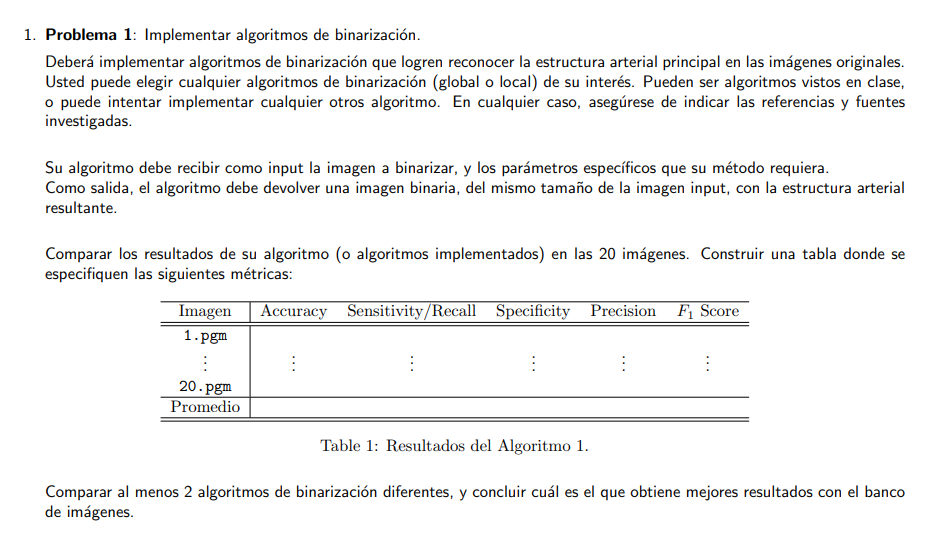

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
from skimage import morphology, filters, exposure, io

C:\Users\juana\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\juana\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\juana\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\juana\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def plot_images(images, titles, cmap='gray'):
    plt.figure(figsize=(15, 5))
    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.imshow(image, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.show()

Obtenemos las imagenes de la carpeta database

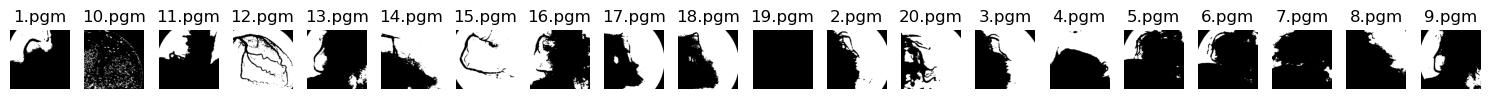

In [3]:
extract_path = 'database' 
files = [os.path.join(root, file)
         for root, dirs, files_in_dir in os.walk(extract_path)
         for file in files_in_dir
         if file.endswith('.pgm') and not file[:-4].endswith('gt')]

fig, axes = plt.subplots(1, len(files), figsize=(15, 5))
if len(files) == 1: 
    axes = [axes]

for ax, image_path in zip(axes, files):
    
    image = Image.open(image_path)
    image_np = np.array(image) 
    _, fixed_thresh_fingerprint = cv2.threshold(image_np, 128, 255, cv2.THRESH_BINARY)
    
    ax.imshow(fixed_thresh_fingerprint, cmap='gray')
    ax.axis('off')
    ax.set_title(os.path.basename(image_path))

plt.tight_layout()
plt.show()

Leemos las imagenes originales y respuesta, y ordenamos ambas en el mismo orden para poder compararlas después

In [4]:
def read_pgm(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    return image

directory = "database"
originales = []
binarias = []

files_gt = []
files_no_gt = []

file_list = os.listdir(directory)
files = [f for f in file_list]


for pgm_file in files:
    if(pgm_file != '.DS_Store') :
        file_path = os.path.join(directory, pgm_file)
        image_data = read_pgm(file_path)
        if "_gt" in pgm_file:
            files_gt.append(pgm_file)
        else:
            files_no_gt.append(pgm_file)

sorted_files_gt = sorted(files_gt, key=lambda x: int(x.split('_')[0]))
sorted_files = sorted(files_no_gt, key=lambda x: int(x.split('.')[0]))

for pgm_file in sorted_files_gt:
    if(pgm_file != '.DS_Store') :
        file_path = os.path.join(directory, pgm_file)
        image_data = read_pgm(file_path)

        binarias.append(image_data)

for pgm_file in sorted_files:
    if(pgm_file != '.DS_Store') :
        file_path = os.path.join(directory, pgm_file)
        image_data = read_pgm(file_path)

        originales.append(image_data)

    

##### Primer metodo de binarización
Utilizando un threshold adaptativo de media

In [5]:
def Calculate_Binary(original_image):
    original_image = np.where(original_image < 30, 255, original_image)
    
    preprocessed_image_bilateral = cv2.bilateralFilter(original_image, 3, 25, 20)

    adaptive_binary_image = cv2.adaptiveThreshold(
        preprocessed_image_bilateral, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 29, 9)
    
    final_filtered_image = cv2.medianBlur(adaptive_binary_image, 1)

    adjusted_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 1))
    morph_opening_adjusted = cv2.morphologyEx(final_filtered_image, cv2.MORPH_OPEN, adjusted_kernel, iterations=1)
    morph_closing_adjusted = cv2.morphologyEx(morph_opening_adjusted, cv2.MORPH_CLOSE, adjusted_kernel, iterations=1)
   
    final_filtered_image = cv2.medianBlur(morph_closing_adjusted, 5)

    return (255 - final_filtered_image)

calculadas_adaptative = []

for i in originales:
    calculadas_adaptative.append(Calculate_Binary(i))

##### Segundo metodo de binarizacion
Utilizando threshold adaptativo gaussiano y filtros. Además de elementos estructurantes

In [6]:
def Calculate_Binary_Advanced(original_image):
    original_image = np.where(original_image < 35, 255, original_image)

    image_float = original_image / 255.0

    image_bilateral = cv2.bilateralFilter(original_image, 9, 23, 95)

    clahe = cv2.createCLAHE(clipLimit=3.46, tileGridSize=(7, 7))
    image_clahe = clahe.apply(image_bilateral)

    adaptive_thresh = cv2.adaptiveThreshold(image_clahe, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 2)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 1))
    closing = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel, iterations=2)


    binary_cleaned = morphology.remove_small_objects(closing > 0, min_size=64)

    filled_cleaned = morphology.remove_small_holes(binary_cleaned, area_threshold=128)

    final_image = (filled_cleaned * 255).astype(np.uint8)

    opening = cv2.morphologyEx(final_image, cv2.MORPH_OPEN, kernel2, iterations=10)

    final_smoothed_image = (255 - opening)

    median_filtered = cv2.medianBlur(final_smoothed_image, 9)

    kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 1))
    dilated = cv2.dilate(median_filtered, kernel3, iterations=10)
    rounded_edges_image = cv2.erode(dilated, kernel3, iterations=20)


    return rounded_edges_image


calculadas_adaptative_gauss = []

for i in originales:
    calculadas_adaptative_gauss.append(Calculate_Binary_Advanced(i))

In [7]:
def binary_image_metrics_by_category(image_true, image_pred):
    if image_true.shape != image_pred.shape:
        raise ValueError("Las imágenes deben tener la misma forma.")

    image_true = (image_true >= 128).astype(np.uint8)
    image_pred = (image_pred >= 128).astype(np.uint8)

    categories = np.unique(image_true)  # Obtener las categorías únicas presentes en la imagen verdadera

    metrics_by_category = {}

    for category in categories:
        true_mask = (image_true == category)
        pred_mask = (image_pred == category)

        TP = np.logical_and(true_mask, pred_mask).sum()
        FP = np.logical_and(true_mask == 0, pred_mask == 1).sum()
        FN = np.logical_and(true_mask == 1, pred_mask == 0).sum()
        TN = np.logical_and(true_mask == 0, pred_mask == 0).sum()

        precision = TP / (TP + FP) if TP + FP != 0 else 0
        recall = TP / (TP + FN) if TP + FN != 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
        specificity = TN / (TN + FP) if TN + FP != 0 else 0

        metrics = {
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1_score,
            'Specificity': specificity
        }

        metrics_by_category[category] = metrics

    
    TP_gen = np.logical_and(image_true, image_pred).sum()
    FP_gen = np.logical_and(image_true == 0, image_pred == 1).sum()
    FN_gen = np.logical_and(image_true == 1, image_pred == 0).sum()
    TN_gen = np.logical_and(image_true == 0, image_pred == 0).sum()

    precision_gen = TP_gen / (TP_gen + FP_gen) if TP_gen + FP_gen != 0 else 0
    recall_gen = TP_gen / (TP_gen + FN_gen) if TP_gen + FN_gen != 0 else 0
    accuracy_gen = (TP_gen + TN_gen) / (TP_gen + TN_gen + FP_gen + FN_gen)
    f1_score_gen = 2 * (precision_gen * recall_gen) / (precision_gen + recall_gen) if precision_gen + recall_gen != 0 else 0
    specificity_gen = TN_gen / (TN_gen + FP_gen) if TN_gen + FP_gen != 0 else 0

    general_metrics = {
        'Precision': precision_gen,
        'Recall': recall_gen,
        'Accuracy': accuracy_gen,
        'F1 Score': f1_score_gen,
        'Specificity': specificity_gen
    }

    return general_metrics, metrics_by_category


In [8]:
def binary_classification(respuestas, binarizaciones):
    conteo = 1
    precisions = []
    recalls = []
    accuracys = []
    f1_scores = []
    specificitys = []
    
    precisions0 = []
    recalls0 = []
    accuracys0 = []
    f1_scores0 = []
    specificitys0 = []
    
    precisions1 = []
    recalls1 = []
    accuracys1 = []
    f1_scores1 = []
    specificitys1 = []
    
    nombres = []
    for binar, resp in zip(respuestas, binarizaciones):
        metrica_gen, metrica_cat = binary_image_metrics_by_category(resp, binar)
        precisions.append(metrica_gen["Precision"])
        recalls.append(metrica_gen["Recall"])
        accuracys.append(metrica_gen["Accuracy"])
        f1_scores.append(metrica_gen["F1 Score"])
        specificitys.append(metrica_gen["Specificity"])
        
        precisions0.append(metrica_cat[0]["Precision"])
        recalls0.append(metrica_cat[0]["Recall"])
        accuracys0.append(metrica_cat[0]["Accuracy"])
        f1_scores0.append(metrica_cat[0]["F1 Score"])
        specificitys0.append(metrica_cat[0]["Specificity"])
        
        precisions1.append(metrica_cat[1]["Precision"])
        recalls1.append(metrica_cat[1]["Recall"])
        accuracys1.append(metrica_cat[1]["Accuracy"])
        f1_scores1.append(metrica_cat[1]["F1 Score"])
        specificitys1.append(metrica_cat[1]["Specificity"])
        nombres.append(str(conteo)+".pmg")
        conteo+=1
    df = pd.DataFrame({"Imagen":nombres, "Accuracy":accuracys, "Recall":recalls, "Specificity":specificitys, "Precision":precisions, "F1 Score":f1_scores})
    promedios = pd.DataFrame({"Promedio Accuracy":[df["Accuracy"].mean()], "Promedio Recall":[df["Recall"].mean()], "Promedio Specificity":[df["Specificity"].mean()], "Promedio Precision":[df["Precision"].mean()], "Promedio F1 Score":[df["F1 Score"].mean()]})
    
    df0 = pd.DataFrame({"Imagen":nombres, "Accuracy":accuracys0, "Recall":recalls0, "Specificity":specificitys0, "Precision":precisions0, "F1 Score":f1_scores0})
    promedios0 = pd.DataFrame({"Promedio Accuracy":[df0["Accuracy"].mean()], "Promedio Recall":[df0["Recall"].mean()], "Promedio Specificity":[df0["Specificity"].mean()], "Promedio Precision":[df0["Precision"].mean()], "Promedio F1 Score":[df0["F1 Score"].mean()]})
    
    df1 = pd.DataFrame({"Imagen":nombres, "Accuracy":accuracys1, "Recall":recalls1, "Specificity":specificitys1, "Precision":precisions1, "F1 Score":f1_scores1})
    promedios1 = pd.DataFrame({"Promedio Accuracy":[df1["Accuracy"].mean()], "Promedio Recall":[df1["Recall"].mean()], "Promedio Specificity":[df1["Specificity"].mean()], "Promedio Precision":[df1["Precision"].mean()], "Promedio F1 Score":[df1["F1 Score"].mean()]})
    return df, promedios, df0, promedios0, df1, promedios1

In [21]:
total, promtotal, total0, prom0, total1, prom1 = binary_classification(binarias, calculadas_adaptative)
total2, promtotal2, total02, prom02, total12, prom12 = binary_classification(binarias, calculadas_adaptative_gauss)

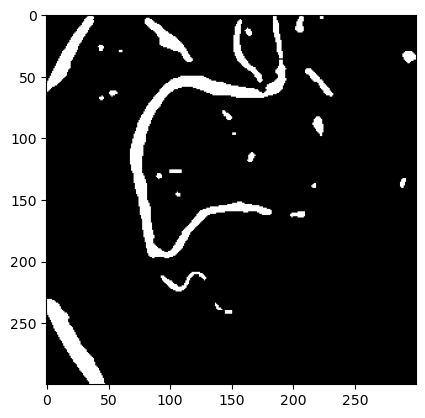

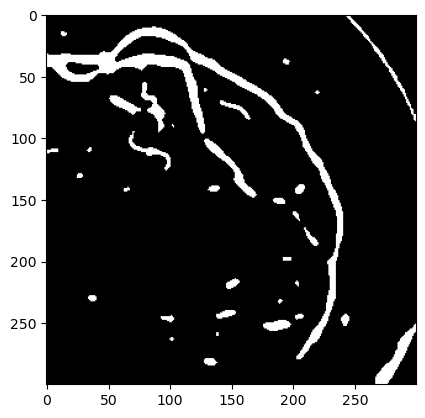

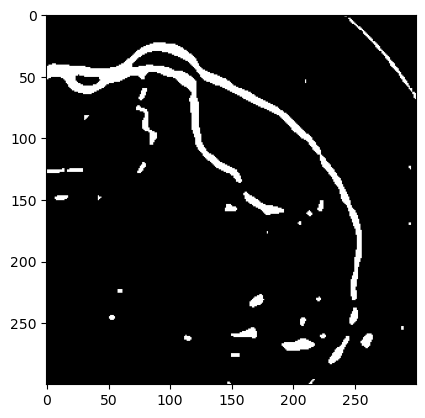

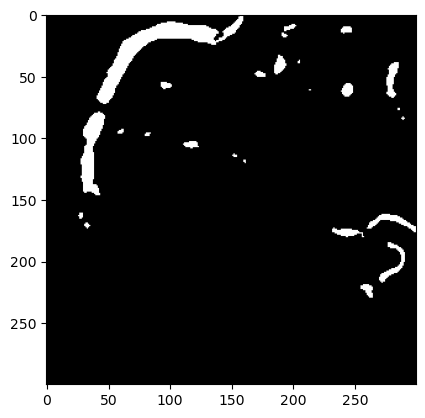

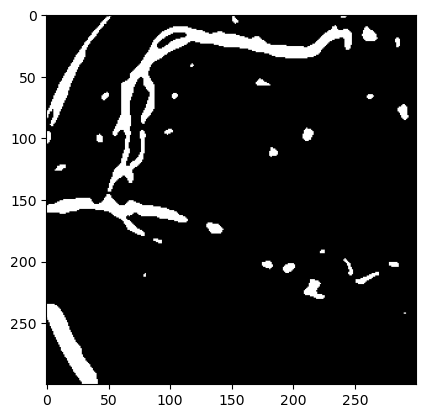

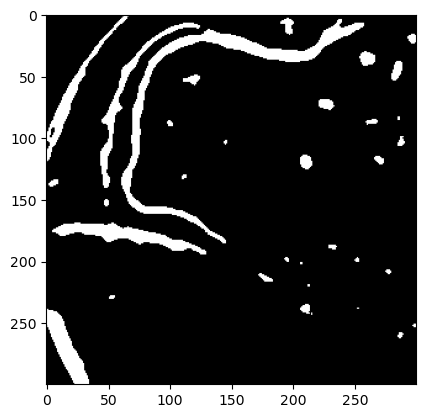

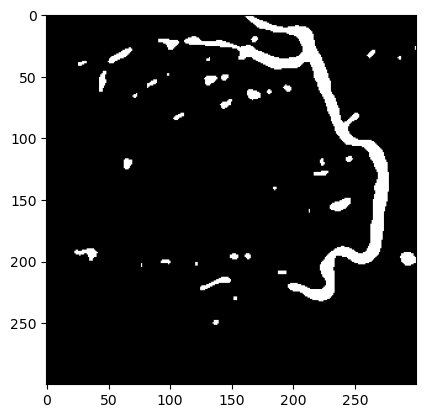

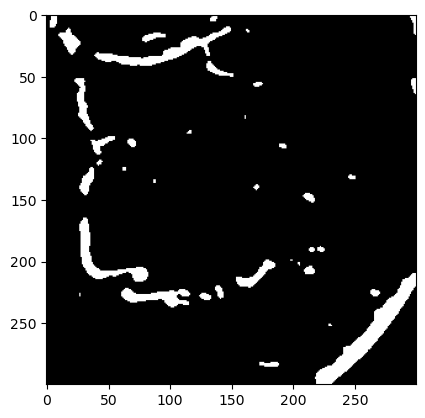

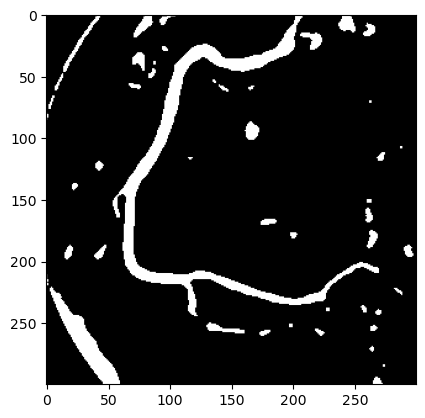

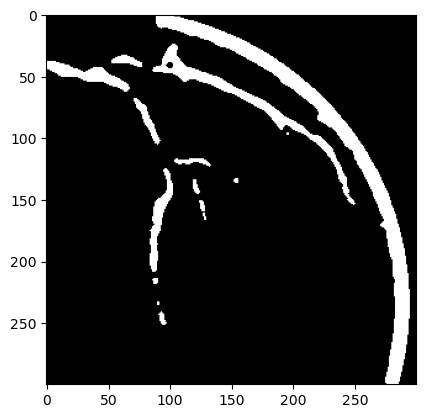

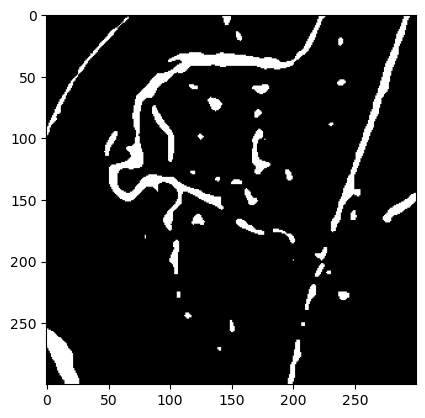

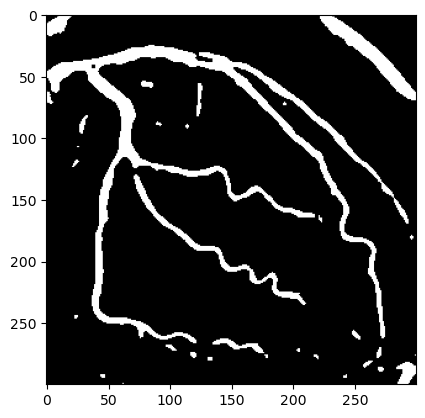

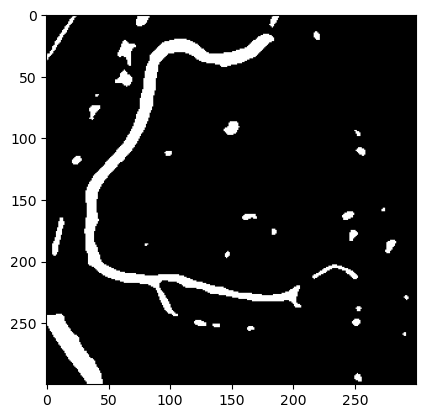

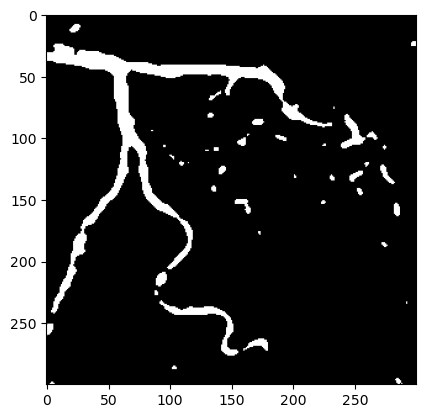

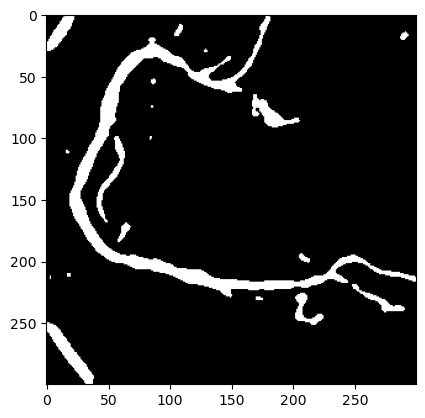

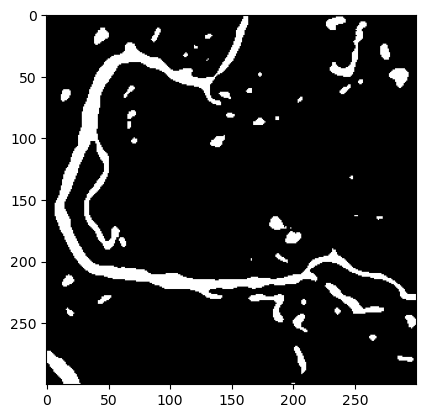

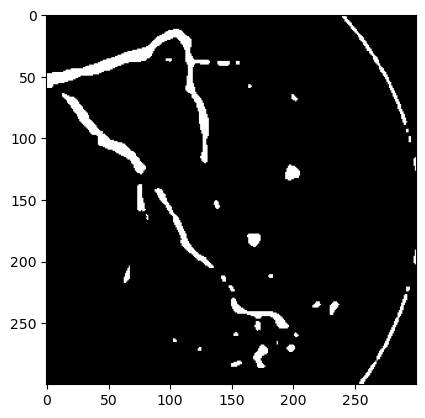

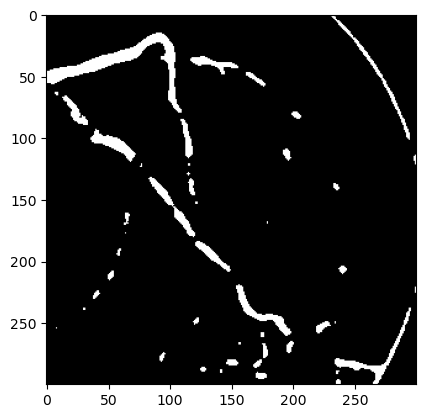

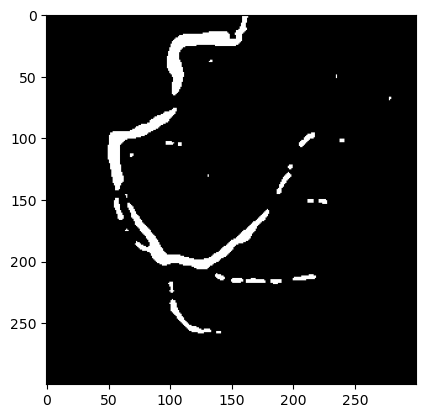

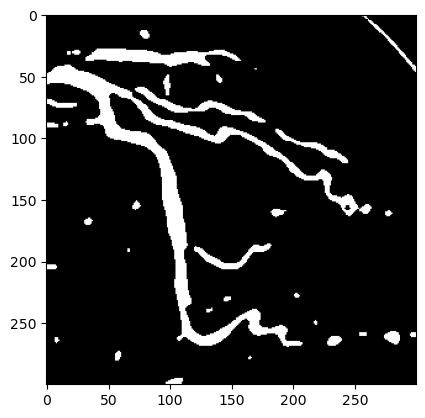

In [11]:
for i in calculadas_adaptative:
    plt.imshow(i, cmap="gray")
    plt.show()

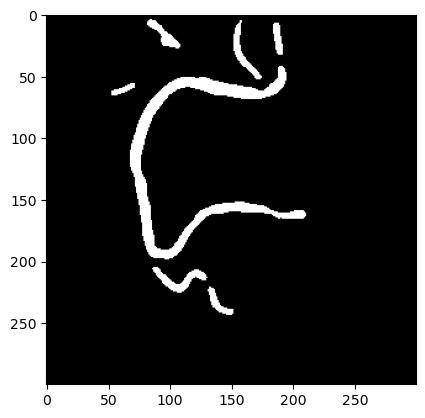

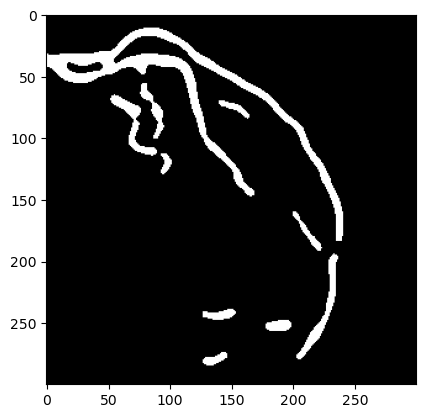

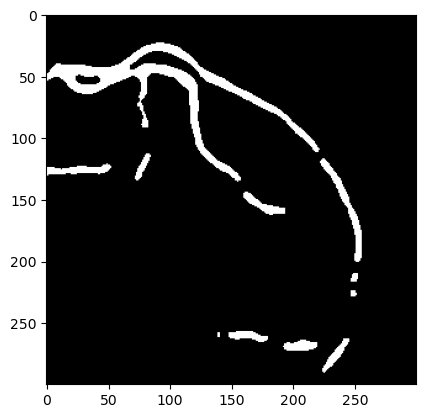

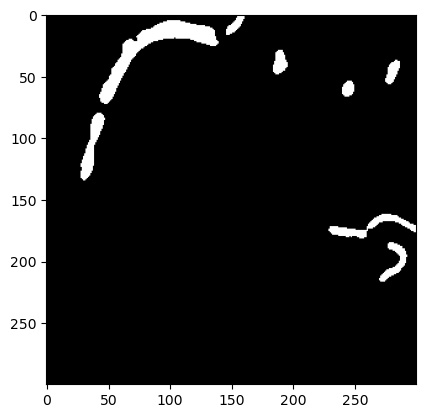

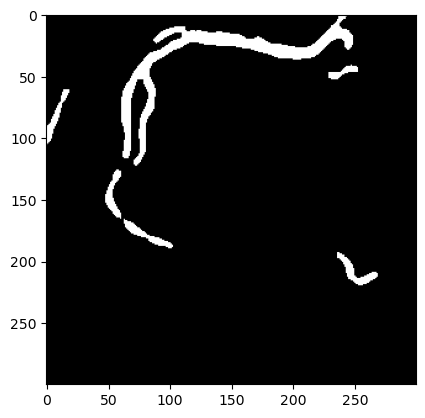

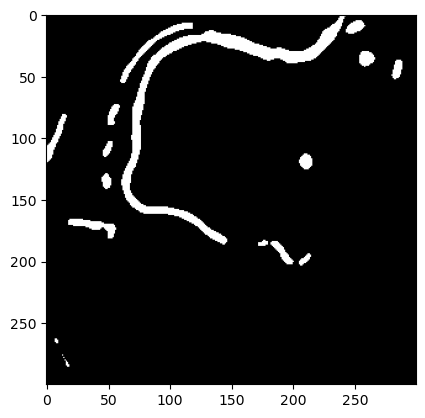

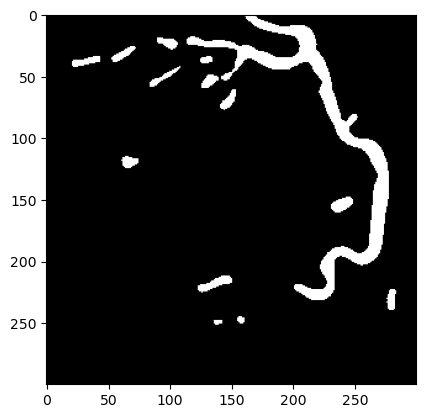

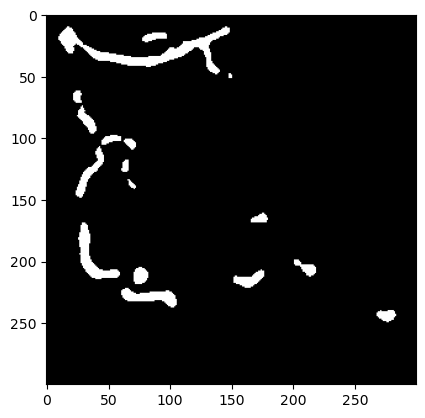

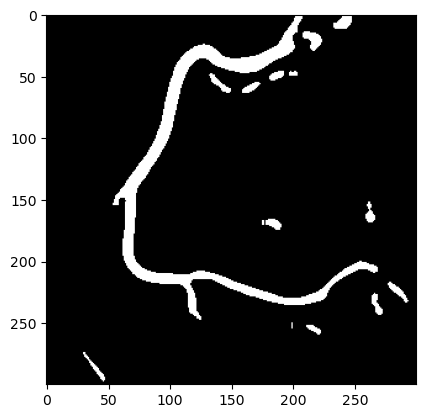

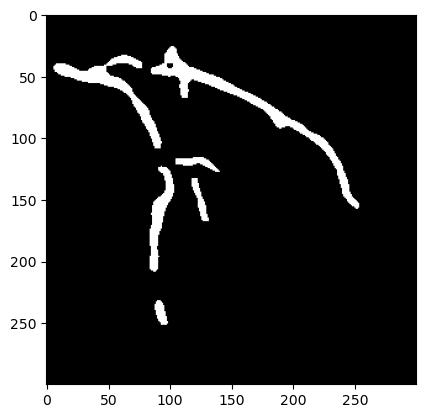

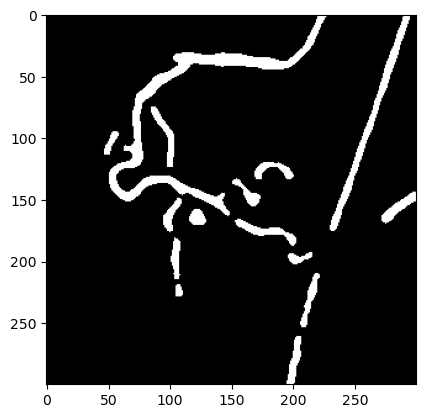

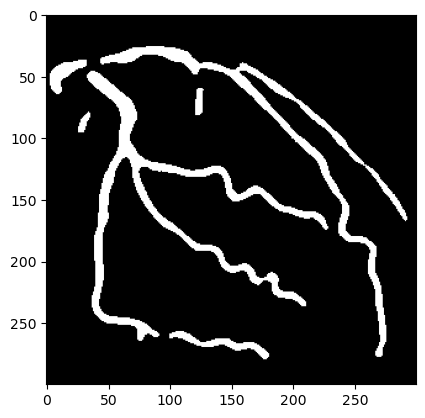

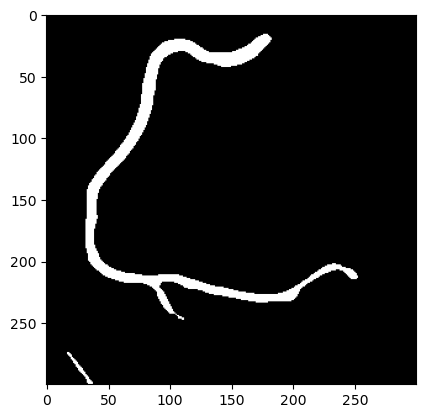

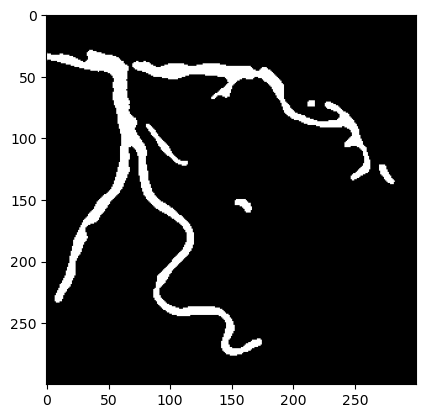

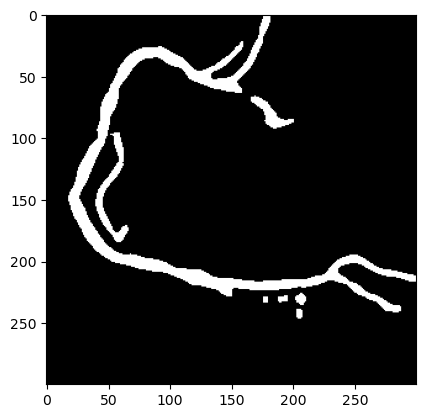

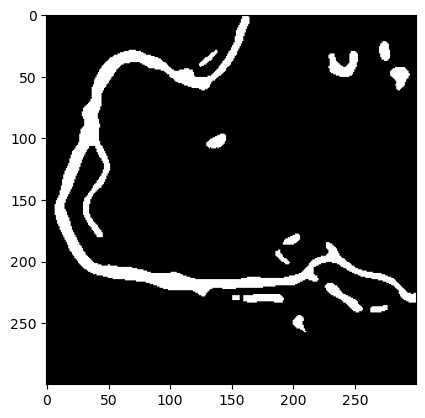

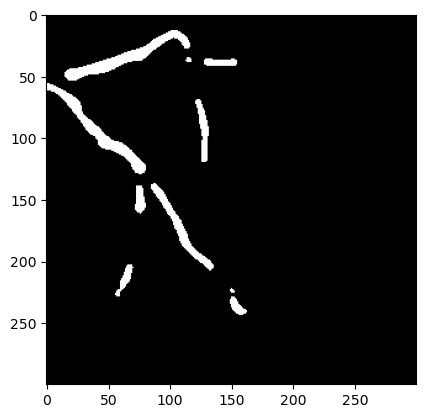

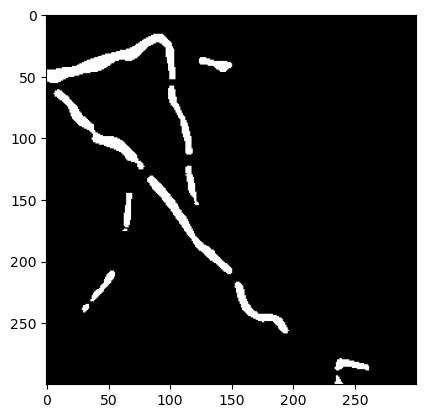

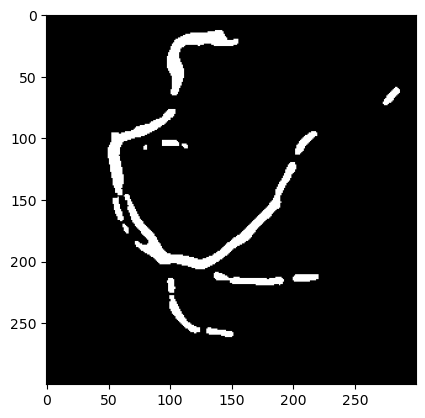

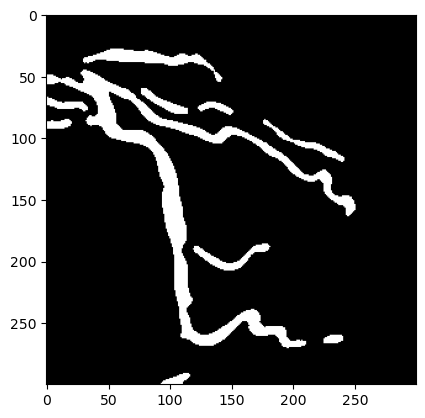

In [12]:
for i in calculadas_adaptative_gauss:
    plt.imshow(i, cmap="gray")
    plt.show()

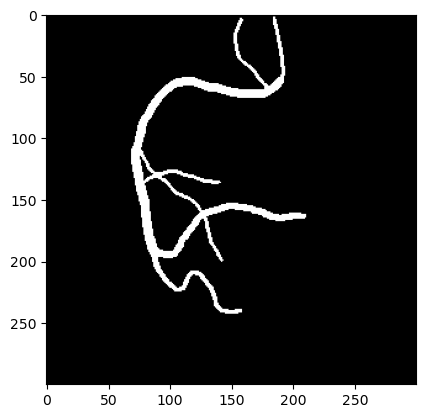

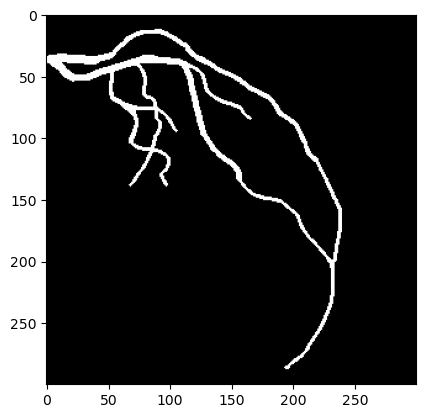

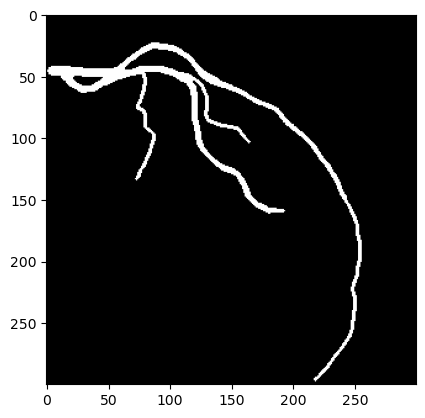

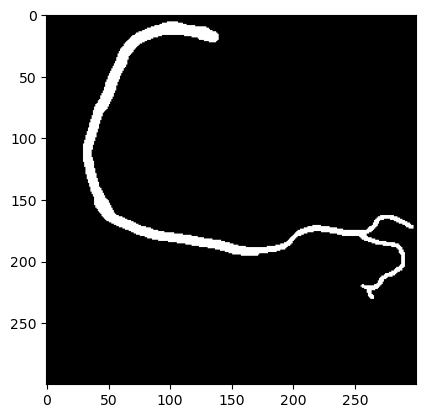

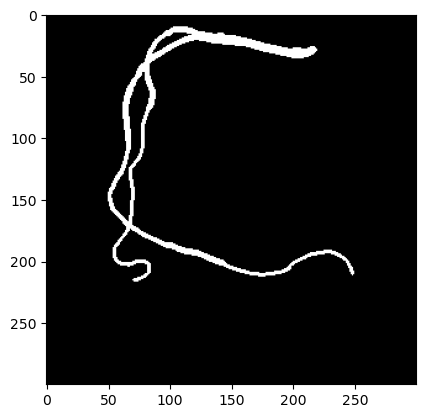

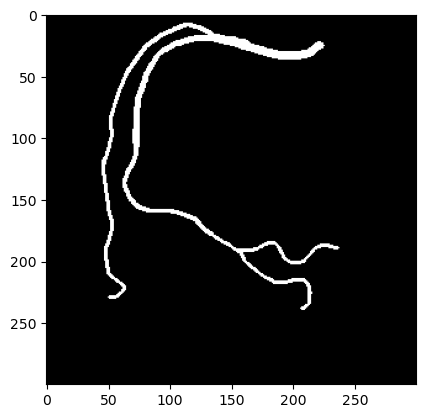

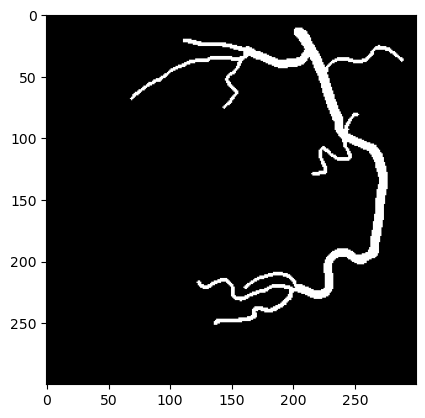

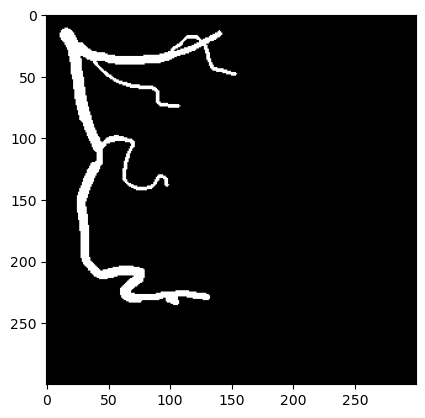

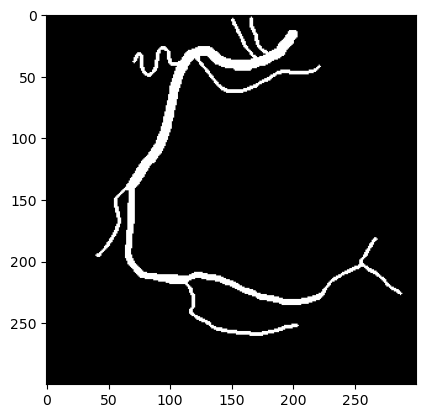

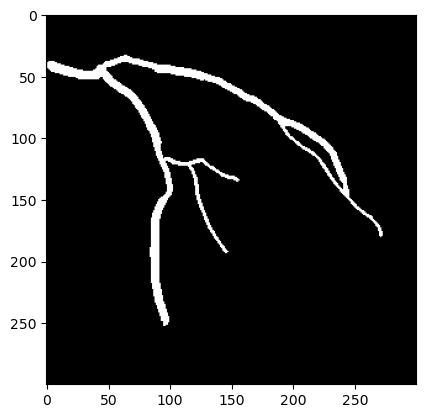

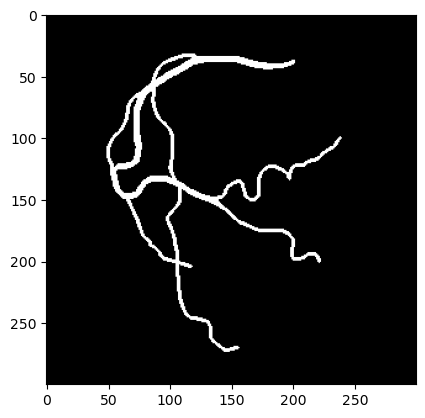

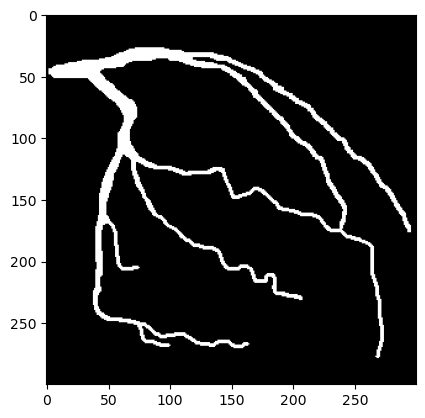

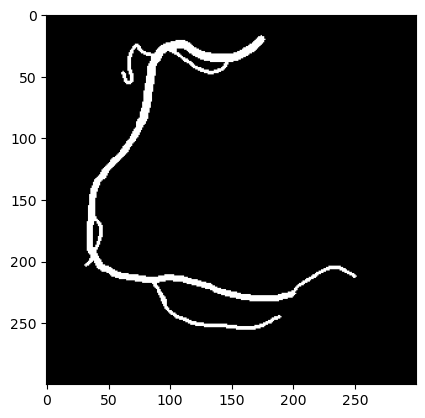

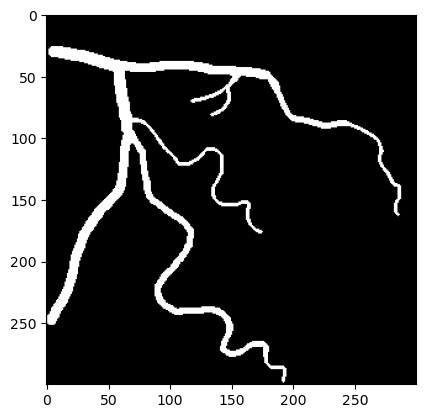

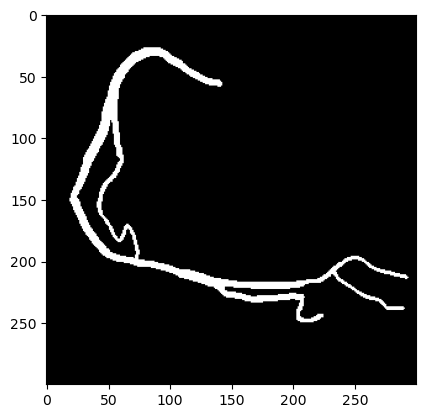

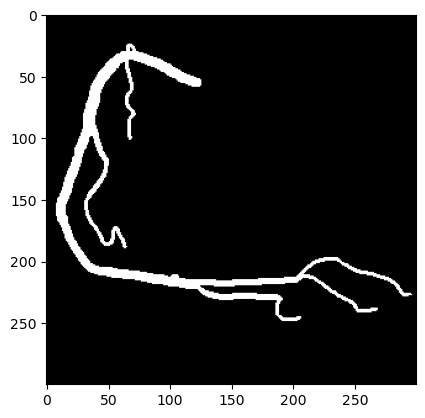

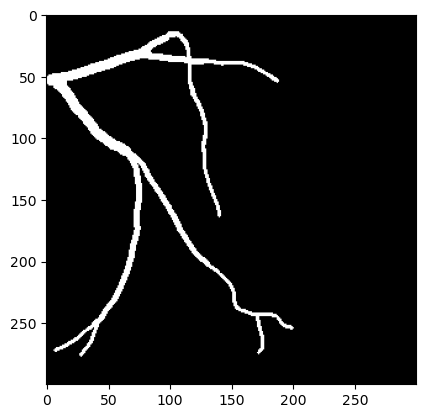

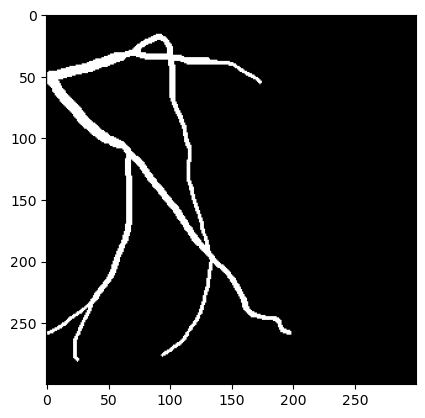

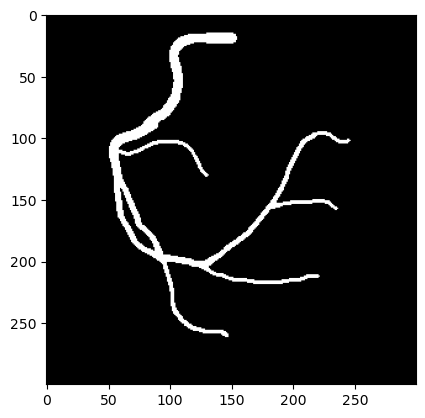

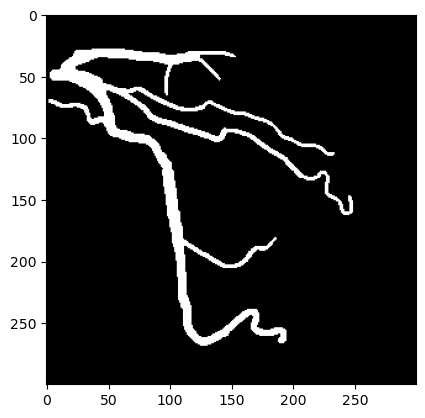

In [13]:
for i in binarias:
    plt.imshow(i, cmap="gray")
    plt.show()

### Resultados Algoritmo de binarizacion adaptativo simple

In [14]:
total

,Imagen,Accuracy,Recall,Specificity,Precision,F1 Score
0,1.pmg,0.951989,0.456965,0.989083,0.758265,0.570264
1,2.pmg,0.955767,0.520175,0.990334,0.810264,0.633594
2,3.pmg,0.968933,0.590790,0.992795,0.838024,0.693017
3,4.pmg,0.962389,0.582682,0.978118,0.524516,0.552071
4,5.pmg,0.937144,0.326445,0.988012,0.694009,0.444029
5,6.pmg,0.936167,0.333469,0.990122,0.751371,0.461928
6,7.pmg,0.961678,0.593411,0.984495,0.703386,0.643735
7,8.pmg,0.949033,0.462577,0.978766,0.571088,0.511137
8,9.pmg,0.945856,0.480532,0.987838,0.780930,0.594963
9,10.pmg,0.923756,0.318916,0.983137,0.649949,0.427881


In [16]:
promtotal

,Promedio Accuracy,Promedio Recall,Promedio Specificity,Promedio Precision,Promedio F1 Score
0,0.951866,0.51985,0.985928,0.727122,0.594938


In [17]:
total0

,Imagen,Accuracy,Recall,Specificity,Precision,F1 Score
0,1.pmg,0.951989,0.989083,0.456965,0.960484,0.974574
1,2.pmg,0.955767,0.990334,0.520175,0.962975,0.976463
2,3.pmg,0.968933,0.992795,0.590790,0.974650,0.983639
3,4.pmg,0.962389,0.978118,0.582682,0.982633,0.980370
4,5.pmg,0.937144,0.988012,0.326445,0.946268,0.966689
5,6.pmg,0.936167,0.990122,0.333469,0.943161,0.966071
6,7.pmg,0.961678,0.984495,0.593411,0.975050,0.979750
7,8.pmg,0.949033,0.978766,0.462577,0.967530,0.973115
8,9.pmg,0.945856,0.987838,0.480532,0.954705,0.970989
9,10.pmg,0.923756,0.983137,0.318916,0.936318,0.959156


In [18]:
prom0

,Promedio Accuracy,Promedio Recall,Promedio Specificity,Promedio Precision,Promedio F1 Score
0,0.951866,0.985928,0.51985,0.963196,0.97435


In [19]:
total1

,Imagen,Accuracy,Recall,Specificity,Precision,F1 Score
0,1.pmg,0.951989,0.456965,0.989083,0.758265,0.570264
1,2.pmg,0.955767,0.520175,0.990334,0.810264,0.633594
2,3.pmg,0.968933,0.590790,0.992795,0.838024,0.693017
3,4.pmg,0.962389,0.582682,0.978118,0.524516,0.552071
4,5.pmg,0.937144,0.326445,0.988012,0.694009,0.444029
5,6.pmg,0.936167,0.333469,0.990122,0.751371,0.461928
6,7.pmg,0.961678,0.593411,0.984495,0.703386,0.643735
7,8.pmg,0.949033,0.462577,0.978766,0.571088,0.511137
8,9.pmg,0.945856,0.480532,0.987838,0.780930,0.594963
9,10.pmg,0.923756,0.318916,0.983137,0.649949,0.427881


In [22]:
prom1

,Promedio Accuracy,Promedio Recall,Promedio Specificity,Promedio Precision,Promedio F1 Score
0,0.951866,0.51985,0.985928,0.727122,0.594938


### Resultados Binarizacion Adaptativa Gauss

In [25]:
total2

,Imagen,Accuracy,Recall,Specificity,Precision,F1 Score
0,1.pmg,0.976022,0.684978,0.990936,0.794763,0.735798
1,2.pmg,0.964322,0.585603,0.991649,0.834981,0.688404
2,3.pmg,0.970622,0.611398,0.991914,0.817578,0.699614
3,4.pmg,0.962933,0.601973,0.975995,0.475735,0.531461
4,5.pmg,0.968300,0.549901,0.987903,0.680492,0.608266
5,6.pmg,0.963989,0.504425,0.988930,0.712066,0.590524
6,7.pmg,0.958867,0.565000,0.985000,0.714221,0.630907
7,8.pmg,0.965022,0.647488,0.978111,0.549417,0.594434
8,9.pmg,0.963489,0.615166,0.986737,0.755837,0.678285
9,10.pmg,0.974244,0.692580,0.988142,0.742401,0.716626


In [26]:
promtotal2

,Promedio Accuracy,Promedio Recall,Promedio Specificity,Promedio Precision,Promedio F1 Score
0,0.964227,0.62132,0.986235,0.731317,0.66424


In [28]:
total02

,Imagen,Accuracy,Recall,Specificity,Precision,F1 Score
0,1.pmg,0.976022,0.990936,0.684978,0.983971,0.987441
1,2.pmg,0.964322,0.991649,0.585603,0.970730,0.981078
2,3.pmg,0.970622,0.991914,0.611398,0.977306,0.984556
3,4.pmg,0.962933,0.975995,0.601973,0.985457,0.980703
4,5.pmg,0.968300,0.987903,0.549901,0.979100,0.983482
5,6.pmg,0.963989,0.988930,0.504425,0.973523,0.981166
6,7.pmg,0.958867,0.985000,0.565000,0.971532,0.978220
7,8.pmg,0.965022,0.978111,0.647488,0.985361,0.981723
8,9.pmg,0.963489,0.986737,0.615166,0.974630,0.980646
9,10.pmg,0.974244,0.988142,0.692580,0.984881,0.986509


In [29]:
prom02

,Promedio Accuracy,Promedio Recall,Promedio Specificity,Promedio Precision,Promedio F1 Score
0,0.964227,0.986235,0.62132,0.975975,0.981039


In [30]:
total12

,Imagen,Accuracy,Recall,Specificity,Precision,F1 Score
0,1.pmg,0.976022,0.684978,0.990936,0.794763,0.735798
1,2.pmg,0.964322,0.585603,0.991649,0.834981,0.688404
2,3.pmg,0.970622,0.611398,0.991914,0.817578,0.699614
3,4.pmg,0.962933,0.601973,0.975995,0.475735,0.531461
4,5.pmg,0.968300,0.549901,0.987903,0.680492,0.608266
5,6.pmg,0.963989,0.504425,0.988930,0.712066,0.590524
6,7.pmg,0.958867,0.565000,0.985000,0.714221,0.630907
7,8.pmg,0.965022,0.647488,0.978111,0.549417,0.594434
8,9.pmg,0.963489,0.615166,0.986737,0.755837,0.678285
9,10.pmg,0.974244,0.692580,0.988142,0.742401,0.716626


In [31]:
prom12

,Promedio Accuracy,Promedio Recall,Promedio Specificity,Promedio Precision,Promedio F1 Score
0,0.964227,0.62132,0.986235,0.731317,0.66424


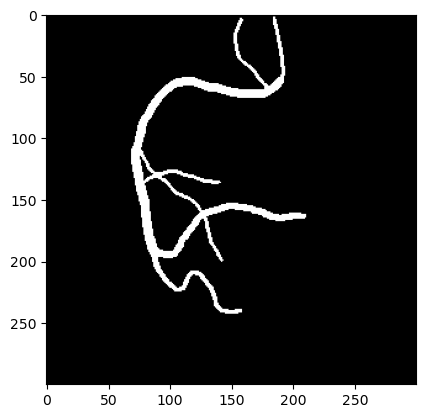

In [34]:
plt.imshow(binarias[0], cmap="gray")

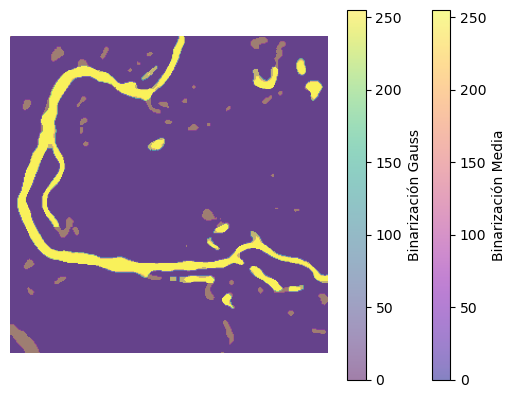

In [62]:
import matplotlib.cm as cm

fig, ax = plt.subplots()

# Mostrar la primera imagen con un cmap diferente y un alpha
im1 = ax.imshow(calculadas_adaptative[15], cmap=cm.plasma, alpha=0.5)

# Mostrar la segunda imagen con un cmap diferente y un alpha
im2 = ax.imshow(calculadas_adaptative_gauss[15], cmap=cm.viridis, alpha=0.5)

# Desactivar los ejes para una mejor visualización
ax.axis('off')

plt.colorbar(im1, ax=ax, label='Binarización Media')
plt.colorbar(im2, ax=ax, label='Binarización Gauss')

# Mostrar la figura
plt.show()